<a href="https://colab.research.google.com/github/thatgeeman/pybx/blob/master/nbs/pybx_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>⚠ Note: walkthrough for v0.2.1 ⚠
>
>run `! pip freeze | grep pybx` to see the installed version. 

# PyBx

PyBx is a simple python package to generate anchor boxes (aka default/prior boxes) for object detection tasks. 

# SSD for Object Detection

This walkthrough is build around the [Single-Shot Detection (SSD)](https://arxiv.org/pdf/1512.02325.pdf) algorithm. The SSD can be imagined as an encoder-decoder model architecture, where the input image is fed into a `backbone` (encoder) to generate inital features, which then goes through a series of 2D convolution layers (decoders) to perform further feature extraction/prediction tasks at each layer. For a single image, each layer in the decoder produces a total of `N x (4 + C)` predictions. Here `C` is the number of classes (plus one for `background` class) in the detection task and 4 comes from the corners of the rectangular bounding box. 

### Usage of the term Feature/Filter/Channel

Channel: RGB dimensione, also called a Filter

Feature: (W,H) of a single channel

## Example case 
For this example, we assume that our input image is a single channel image is of shape `[B, 3, 300, 300]` where `B` is the batch size. Assuming that a pretrained `VGG-16` is our model `backbone`, the output feature shape would be: `[B, 512, 37, 37]`. Meaning that, 512 channels of shape `[37, 37]` were extracted from each image in the batch. In the subsequent decoder layers, for simplicity we double the channels while halving the feature shape using `3x3` `stride=2` convolutions (except for first decoder layer where convolution is not applied). This results in the following shapes:

```python
torch.Size([-1, 512, 37, 37])  # inp from vgg-16 encoder
torch.Size([-1, 1024, 18, 18]) # first layer logits
torch.Size([-1, 2048, 8, 8])   # second layer logits
torch.Size([-1, 4096, 3, 3])   # third layer logits
```

<img src="https://lilianweng.github.io/lil-log/assets/images/SSD-box-scales.png" width="500" />

## Sample image
Image obtained from USC-SIPI Image Database. 
The USC-SIPI image database is a collection of digitized images. It is maintained primarily to support research in image processing, image analysis, and machine vision. The first edition of the USC-SIPI image database was distributed in 1977 and many new images have been added since then.

Set working directory.

In [1]:
import os
os.environ["DATADIR"] = "../data"

Install package if not already present.

In [2]:
%%bash
EXISTS=$(pip freeze | grep pybx | wc -l)
date
if [ $EXISTS -eq 0 ]
then 
    pip install pybx
else
    pip freeze | grep pybx
fi

Tue Mar  8 06:41:11 PM CET 2022
-e git+ssh://git@github.com/thatgeeman/pybx.git@4a154b42fb1faa6b4731540d96b1575e90ca2b6b#egg=pybx


In [3]:
%%bash
echo $DATADIR
mkdir -p $DATADIR
wget -q -O $DATADIR/image.jpg 'https://sipi.usc.edu/database/download.php?vol=misc&img=5.1.12'
ls $DATADIR

../data
annots_iou.json
annots.json
annots_key.json
annots_rand.json
box-1.png
box-2.png
box-3.png
box-4.png
box-5.png
image.jpg
NOTES.md
README.md


SSL_INIT


## About anchor Boxes

We are expected to provide our models with "good" anchor (aka default/prior) boxes. Strong opinion: Our model is [only as good as the initial anchor boxes](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) that we generate. Inorder to improve the coverage of our model, we tend to add additional anchor boxes of different aspect ratios. Now, for a single image, each layer in the decoder produces a total of `N x A x (4 + C)` predictions. Here `A` is the number of aspect ratios to generate additional anchor boxes.

### Task description

Our aim is to find the maximum number of anchor boxes in varying sizes `feature_szs` and aspect ratios `asp_ratios` across the entire image. We apply no filtering to get rid of low (IOU) anchors.

<img src="https://lilianweng.github.io/lil-log/assets/images/SSD-framework.png" width="600" />

In [4]:
feature_szs = [(37,37), (18,18), (8,8), (3,3)]

In [5]:
asp_ratios = [1/2., 1., 2.]

In [6]:
from operator import __mul__
n_boxes = sum([__mul__(*f) for f in feature_szs]) 
print(f'minimum anchor boxes with 1 aspect ratio: {n_boxes}')
print(f'minimum anchor boxes with {len(asp_ratios)} aspect ratios: {n_boxes*len(asp_ratios)}')

minimum anchor boxes with 1 aspect ratio: 1766
minimum anchor boxes with 3 aspect ratios: 5298


# Loading an image

In [7]:
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import json

In [8]:
datadir = Path(os.environ["DATADIR"])
datadir

PosixPath('../data')

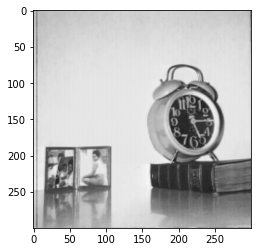

In [9]:
im = Image.open(datadir/"image.jpg").convert('RGB').resize([300,300])
_ = plt.imshow(im)
im.save(datadir/"image.jpg")

In [10]:
im.size

(300, 300)

We also make 2 truth bounding boxes `bbox` for this image around the clock and the photoframe in `pascal voc` format:

In [11]:
bbox = [dict(x_min=150, y_min=70, x_max=270, y_max=220, label='clock'),
        dict(x_min=10, y_min=180, x_max=115, y_max=260, label='frame'),]
bbox

[{'x_min': 150, 'y_min': 70, 'x_max': 270, 'y_max': 220, 'label': 'clock'},
 {'x_min': 10, 'y_min': 180, 'x_max': 115, 'y_max': 260, 'label': 'frame'}]

Save annotations as a json file.

In [12]:
with open(datadir/'annots.json', 'w') as f:
  f.write(json.dumps(bbox))

In [13]:
type(bbox[0])

dict

# Using PyBx

In [14]:
from pybx import anchor

image_sz = (300, 300, 3)  # W, H, C
feature_sz = (3, 3)       # number of features along W, H
asp_ratio = 1.            # aspect ratio of the anchor box

anchors, labels = anchor.bx(image_sz, feature_sz, asp_ratio)

There are several ways to visualize the anchors. First we import the `vis` method.

In [15]:
from pybx import vis

In [16]:
bbox

[{'x_min': 150, 'y_min': 70, 'x_max': 270, 'y_max': 220, 'label': 'clock'},
 {'x_min': 10, 'y_min': 180, 'x_max': 115, 'y_max': 260, 'label': 'frame'}]

In [17]:
image_sz

(300, 300, 3)

### Visualizing the locally stored `image.png` with provided bounding boxes.

In [18]:
im.size

(300, 300)

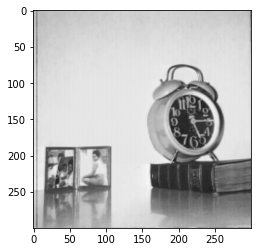

In [19]:
plt.imshow(im)

In [20]:
image_arr = np.array(im)

In [21]:
v = vis.VisBx(image_arr=image_arr, 
              annots=bbox, 
              color={'frame':'red', 'clock':'blue'}) 

<AxesSubplot:>

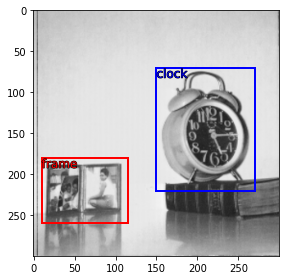

In [22]:
v.show()  # without any arguments

Pass arguments to `show` method to overlay with calculated anchor boxes.

<AxesSubplot:>

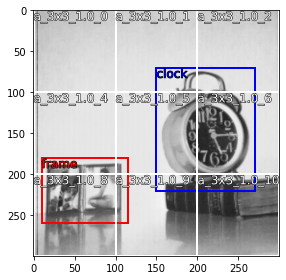

In [23]:
v.show(anchors, labels)

### Using the `sample=True` parameter to load a file 
By default it looks in the current path `pth="."` for an image file `img_fn="image.png"` and annotations file `ann_fn="annots.json"`.

In [24]:
v = vis.VisBx(image_sz=(300,300,3), 
              color={'frame':'red', 'clock':'blue'}, 
              img_fn=datadir/'image.jpg',
              ann_fn=datadir/'annots.json')

<AxesSubplot:>

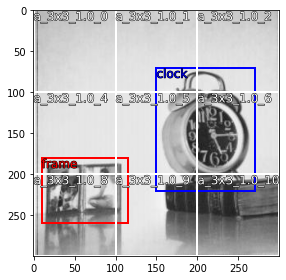

In [25]:
v.show(anchors, labels)

### Using randomly generated noise as `image_arr`

In [27]:
v = vis.VisBx(random_img_sz=(300,300,3))

<AxesSubplot:>

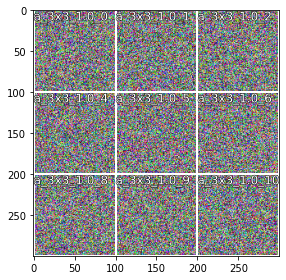

In [28]:
v.show(anchors, labels)

The boxes in white are the anchor boxes. We can hightlight them with a different color by looking up specific box labels.

In [29]:
anchors.shape, labels

((16, 4),
 (#16) ['a_3x3_1.0_0','a_3x3_1.0_1','a_3x3_1.0_2','a_3x3_1.0_3','a_3x3_1.0_4','a_3x3_1.0_5','a_3x3_1.0_6','a_3x3_1.0_7','a_3x3_1.0_8','a_3x3_1.0_9'...])

We see there are 16 labels and box coordinates reported by `anchor.bx()`, but we are certain that there are only 9 anchor boxes possible for our `feature_sz=3x3` and single `asp_ratio`. Out of the 16 calculated by `anchor.bx()`, 7 of them are considered `invalid` (they are not true anchor boxes) by `pybx` and are not shown or taken into account during further processing. `anchor.bx` in `v0.1.3` preserves them and their labels, but does not use them for calculations or visualisation, once instantiated as a `MultiBx`. To wrap a set of coordinates as `MultiBx`, we can use the `mbx()` method. 

In [30]:
from pybx.basics import *

b = mbx(anchors, labels)  # instantiates MultiBx for us

In [31]:
type(b)

pybx.basics.MultiBx

We can iterate over a `MultiBx` object using list comprehension to understand the internal checks:

In [32]:
[(i, b_.valid()) for i, b_ in enumerate(b)]  # only valid boxes shown

[(0, True),
 (1, True),
 (2, True),
 (3, True),
 (4, True),
 (5, True),
 (6, True),
 (7, True),
 (8, True)]

`b_.valid()` returned `True` meaning that the box is considered valid. 

We can also calculate the areas of these boxes.

Each box `b_` of the `MultiBx` b is of type `BaseBx` which has some additional methods.

In [33]:
[b_.area() for b_ in b] 

[10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0]

Each `BaseBx` is also pseudo-iterable (calling an iterator returns `self` itself and not the coordinates or labels).

In [34]:
b_ = b[0]
[x for x in b_]

We can also stack the `BxTypes`. Issues a `UserWarning` if we try to add `BaseBx`+`MultiBx` or `BaseBx`+`BaseBx`. This is to preserve the philosophy of a `BaseBx`, since adding something to a `BaseBx`, which should technically only hold a single coordinate and label, makes the result a `MultiBx`.

In [35]:
b_s = b_ + b_
b_s.coords, b_s.label

/mnt/data/projects/pybx/src/pybx/basics.py:123: BxViolation: Change of object type imminent if trying to add <class 'pybx.basics.BaseBx'>+<class 'pybx.basics.BaseBx'>. Use <class 'pybx.basics.BaseBx'>+<class 'pybx.basics.BaseBx'> instead or basics.stack_bxs().
  warnings.warn(BxViolation(f'Change of object type imminent if trying to add '


(array([[  0.,   0., 100., 100.],
        [  0.,   0., 100., 100.]]),
 ['a_3x3_1.0_0', 'a_3x3_1.0_0'])

To safely add two boxes, use `basics.stack_bxs()` method.

In [36]:
stack_bxs(b_, b_).coords

array([[  0.,   0., 100., 100.],
       [  0.,   0., 100., 100.]])

From `v1.0.0` `BaseBx` can be iterated. What does it mean to iterate a single coordinate. Technically it should return each point of the coordinate. But `BaseBx` behaves differently on being iterated. It returns the `BaseBx` itself.

In [37]:
[x for x in b_]

To truly iterate over the coordinates and label, one must do:

In [38]:
[x for x in b_.values()]

[0.0, 0.0, 100.0, 100.0, 'a_3x3_1.0_0']

In [39]:
# or 
# [x.label for x in b_]
[x.coords for x in b_]

[array([  0.,   0., 100., 100.])]

Coming back to the `MultiBx` types, we can display the coordinates of the valid boxes:

In [40]:
[b_.coords for b_ in b]  # selected boxes only!

[array([  0.,   0., 100., 100.]),
 array([100.,   0., 200., 100.]),
 array([200.,   0., 300., 100.]),
 array([  0., 100., 100., 200.]),
 array([100., 100., 200., 200.]),
 array([200., 100., 300., 200.]),
 array([  0., 200., 100., 300.]),
 array([100., 200., 200., 300.]),
 array([200., 200., 300., 300.])]

Displaying the labels of valid boxes

In [41]:
[b_.label for b_ in b]  # selected boxes only!

[['a_3x3_1.0_0'],
 ['a_3x3_1.0_1'],
 ['a_3x3_1.0_2'],
 ['a_3x3_1.0_4'],
 ['a_3x3_1.0_5'],
 ['a_3x3_1.0_6'],
 ['a_3x3_1.0_8'],
 ['a_3x3_1.0_9'],
 ['a_3x3_1.0_10']]

We can ofcourse see all the 16 boxes calculated by `anchor.bx()` from the `MultiBx` as well:

In [42]:
b.coords, b.label

(array([[  0.,   0., 100., 100.],
        [100.,   0., 200., 100.],
        [200.,   0., 300., 100.],
        [300.,   0., 300., 100.],
        [  0., 100., 100., 200.],
        [100., 100., 200., 200.],
        [200., 100., 300., 200.],
        [300., 100., 300., 200.],
        [  0., 200., 100., 300.],
        [100., 200., 200., 300.],
        [200., 200., 300., 300.],
        [300., 200., 300., 300.],
        [  0., 300., 100., 300.],
        [100., 300., 200., 300.],
        [200., 300., 300., 300.],
        [300., 300., 300., 300.]]),
 (#16) ['a_3x3_1.0_0','a_3x3_1.0_1','a_3x3_1.0_2','a_3x3_1.0_3','a_3x3_1.0_4','a_3x3_1.0_5','a_3x3_1.0_6','a_3x3_1.0_7','a_3x3_1.0_8','a_3x3_1.0_9'...])

> The `vis.VisBx` internally converts all coordinates in `list`/`json`/`ndarray` to a `MultiBx` and shows only `valid` boxes. 

We can also overlay the features generated by the model on the original image. `logits=True` generates random logits (`np.random.randn`) of the same shape as feature sizes for illustration purposes. 

To aid the explainability of the model, actual model logits can also be passed into the same parameter `logits` as an array or detached tensor.

<AxesSubplot:>

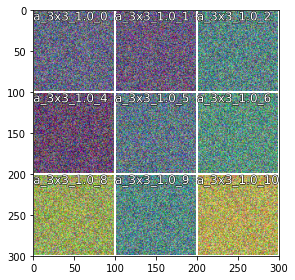

In [44]:
# ask VisBx to use random logits with logits=True
vis.VisBx(random_img_sz=image_sz, logits=True, feature_sz=feature_sz).show(anchors, labels)

In [45]:
# ask VisBx to use passed logits with logits=logits
logits = np.random.randn(3,3)  # assuming these are model logits
logits

array([[ 1.20188782, -1.19087278,  0.70651543],
       [-1.42009278, -0.91944115,  0.5668216 ],
       [ 0.10349734,  0.73877671,  0.50471034]])

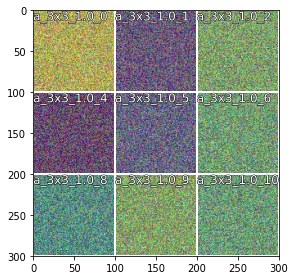

In [47]:
v = vis.VisBx(random_img_sz=image_sz, logits=logits).show(anchors, labels)

We can hightlight them with a different color if needed. Anchor boxes generated with `named=True` parameter automatically sets the label for each box in the format: `{anchor_sfx}_{feature_sz}_{asp_ratio}_{box_number}`. `anchor_sfx` is also an optional parameter that can be passed to `anchor.bx()`. Here we change the color of one anchor box and one ground truth box.

In [48]:
labels[4]

'a_3x3_1.0_4'

<AxesSubplot:>

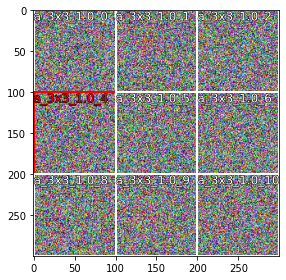

In [50]:
v = vis.VisBx(random_img_sz=image_sz)
v.show(anchors, labels, color={'a_3x3_1.0_4':'red', 'clock':'orange'})

The box `a_3x3_1.0_4` is not fully highlighted due to overlapping edges of other anchor boxes. A quick and dirty fix to isolate the said box:

<AxesSubplot:>

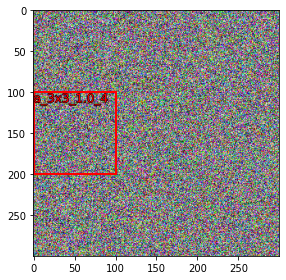

In [51]:
v.show([a for i, a in enumerate(anchors) if labels[i]=='a_3x3_1.0_4'], 
       [l for l in labels if l=='a_3x3_1.0_4'],
       color={'a_3x3_1.0_4':'red', 'clock':'orange'})

# Working with mulitple feature sizes and aspect ratios
Finally we calculate anchor boxes for multiple feature sizes and aspect ratios.

In [52]:
feature_szs = [(3, 3), (2, 2)]
asp_ratios = [1/2., 2.]

anchors, labels = anchor.bxs(image_sz, feature_szs, asp_ratios)

This is essentially a wrapper to do list comprehension over the passed feature sizes and aspect ratios (but additionally stacks them together into an ndarray).

```
[anchor.bx(image_sz, f, ar) for f in feature_szs for ar in asp_ratios]
```

In [53]:
labels[4], labels[32]

('a_3x3_0.5_4', 'a_2x2_0.5_0')

<AxesSubplot:>

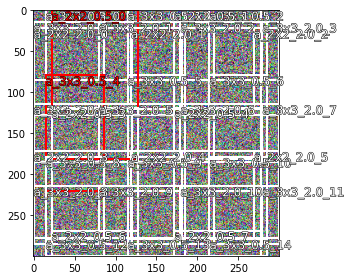

In [55]:
v = vis.VisBx(random_img_sz=image_sz)
v.show(anchors, labels, color={'a_3x3_0.5_4':'red', 'a_2x2_0.5_0':'red'})

As simple as that! Do leave a star or raise issues and suggestions on the project page if you found this useful! 

Project page: [GitHub](https://github.com/thatgeeman/pybx) 

PyPi Package: [PyBx](https://pypi.org/project/pybx/)